In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hnmchallenge.constant import *
from hnmchallenge.data_reader import DataReader
from hnmchallenge.datasets.all_items_last_month_last_2nd_week import \
    AILML2WDataset
from hnmchallenge.datasets.all_items_last_month_last_3rd_week import \
    AILML3WDataset
from hnmchallenge.datasets.all_items_last_month_last_week import AILMLWDataset
from hnmchallenge.datasets.last_month_last_week_dataset import LMLWDataset
from hnmchallenge.evaluation.python_evaluation import map_at_k
from hnmchallenge.models_prediction.recs_interface import RecsInterface
from hnmchallenge.matplotlib_utils.setup_plot import setup_plot
import os


In [2]:
dataset = AILMLWDataset()
articles_df = dataset.get_articles_df()
fd = dataset.get_full_data()
customers_df=dataset.get_customers_df()

In [3]:
trans = dataset.get_full_data()
trans["last_buy"] = trans.groupby(DEFAULT_ITEM_COL)["t_dat"].transform(max)
trans["first_buy"] = trans.groupby(DEFAULT_ITEM_COL)["t_dat"].transform(min)
trans["article_life"] = (trans["last_buy"] - trans["first_buy"])
trans['article_life'] = pd.to_numeric(trans['article_life'].dt.days, downcast='integer')
trans["article_life"]=trans["article_life"].replace(0, 1)



In [4]:
trans

,t_dat,customer_id,article_id,price,sales_channel_id,last_buy,first_buy,article_life
0,2018-09-20,0,0,0.050831,2,2019-06-16,2018-09-20,269
1,2018-09-20,0,1,0.030492,2,2019-12-27,2018-09-20,463
2,2018-09-20,1,2,0.015237,2,2019-05-25,2018-09-20,247
3,2018-09-20,1,3,0.016932,2,2020-02-08,2018-09-20,506
4,2018-09-20,1,4,0.016932,2,2020-03-04,2018-09-20,531
...,...,...,...,...,...,...,...,...
31788319,2020-09-22,212537,102734,0.059305,2,2020-09-22,2020-09-07,15
31788320,2020-09-22,212537,97490,0.042356,2,2020-09-22,2020-07-21,63
31788321,2020-09-22,1090369,104185,0.043203,1,2020-09-22,2020-09-18,4
31788322,2020-09-22,729233,70100,0.006763,1,2020-09-22,2019-09-13,375


In [5]:
#trans.groupby(DEFAULT_ITEM_COL).count().reset_index()
trans["pop"] = trans.groupby(DEFAULT_ITEM_COL).transform("count")["customer_id"]

In [6]:
trans

,t_dat,customer_id,article_id,price,sales_channel_id,last_buy,first_buy,article_life,pop
0,2018-09-20,0,0,0.050831,2,2019-06-16,2018-09-20,269,633
1,2018-09-20,0,1,0.030492,2,2019-12-27,2018-09-20,463,434
2,2018-09-20,1,2,0.015237,2,2019-05-25,2018-09-20,247,42
3,2018-09-20,1,3,0.016932,2,2020-02-08,2018-09-20,506,1836
4,2018-09-20,1,4,0.016932,2,2020-03-04,2018-09-20,531,1792
...,...,...,...,...,...,...,...,...,...
31788319,2020-09-22,212537,102734,0.059305,2,2020-09-22,2020-09-07,15,193
31788320,2020-09-22,212537,97490,0.042356,2,2020-09-22,2020-07-21,63,513
31788321,2020-09-22,1090369,104185,0.043203,1,2020-09-22,2020-09-18,4,6
31788322,2020-09-22,729233,70100,0.006763,1,2020-09-22,2019-09-13,375,866


In [7]:
# create the whole span of time in weeks

# Timestamp('2018-09-20 00:00:00')
start_date = trans["t_dat"].min()

# Timestamp('2020-09-22 00:00:00')
end_date = trans["t_dat"].max()

In [9]:
trans_item = trans[[DEFAULT_ITEM_COL, "first_buy", "last_buy", "article_life"]].drop_duplicates()

In [10]:
current_interval_start = start_date
offset = pd.to_timedelta(7, unit='d')

art_in_time = []
time_arr = []

while current_interval_start < end_date:
    current_interval_end = current_interval_start + offset
    living_article = trans_item[((trans_item["first_buy"]<=current_interval_start) & (trans_item["last_buy"]>=current_interval_start))]
    
    art_in_time.append(len(living_article))
    time_arr.append(current_interval_end)
    
    current_interval_start = current_interval_end

In [11]:
living_article_df = pd.DataFrame(zip(art_in_time, time_arr), columns=["living_article", "date"])

In [12]:
setup_plot(200, fig_ratio=0.5, style_sheet="base", font_size=8)
sns.lineplot(data=living_article_df, x="date", y="living_article", color="red")

plt.xticks(rotation=45)
plt.ylabel("Articles alive")
plt.xlabel("Time")

# plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.0)
# plt.savefig(
#     "{}/GitProjects/HnMChallenge/plots/{}.pdf".format(os.environ["HOME"], "alive_article"),
#     #bbox_inches="tight",
# )

OSError: '/home/aayush/GitProjects/InductiveRec/irec/experiments/plot/matplotlib_utils/styles/base.mplstyle' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

In [12]:
art_life_df=trans[[DEFAULT_ITEM_COL, "article_life", "pop"]].drop_duplicates()
art_life_df["month_article_life"]=(art_life_df["article_life"]/30).apply(np.ceil)

Missing colon in file '/home/edoardo/GitProjects/InductiveRec/irec/experiments/plot/matplotlib_utils/styles/base.mplstyle', line 40 ('grid.zorder=-1')


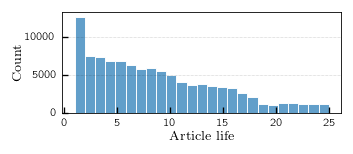

In [55]:
#sns.set_style("whitegrid")
setup_plot(200, fig_ratio=0.4, style_sheet="base", font_size=8)
sns.histplot(art_life_df, x="month_article_life", bins=25, cumulative=False, edgecolor="white", alpha=0.7)
plt.xlabel("Article life")
plt.gca().xaxis.grid(False)
#plt.gca().tick_params(color='gray')

#ax2=plt.gca().twinx()
#sns.kdeplot(data=art_life_df, x="month_article_life", alpha=0.7, ax=ax2, color="black")

# remove right y-axis stuff
#plt.gca().yaxis.set_ticklabels([]) 
#plt.ylabel("")
#plt.gca().tick_params(right = False)

plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.0)
plt.savefig(
    "{}/GitProjects/HnMChallenge/plots/{}.pdf".format(os.environ["HOME"], "distr_article_life"),
    #bbox_inches="tight",
)

Missing colon in file '/home/edoardo/GitProjects/InductiveRec/irec/experiments/plot/matplotlib_utils/styles/base.mplstyle', line 40 ('grid.zorder=-1')


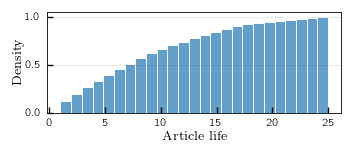

In [14]:
#sns.set_style("whitegrid")
setup_plot(200, fig_ratio=0.4, style_sheet="base", font_size=8)
sns.histplot(art_life_df, x="month_article_life", bins=25, cumulative=True, stat="density", edgecolor="white", alpha=0.7)
plt.xlabel("Article life")
plt.gca().xaxis.grid(False)
#plt.gca().tick_params(color='gray')

plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.0)
plt.savefig(
    "{}/GitProjects/HnMChallenge/plots/{}.pdf".format(os.environ["HOME"], "cumulative_article_life"),
    #bbox_inches="tight",
)

In [15]:
trans

,t_dat,customer_id,article_id,price,sales_channel_id,last_buy,first_buy,article_life,pop
0,2018-09-20,0,0,0.050831,2,2019-06-16,2018-09-20,269,633
1,2018-09-20,0,1,0.030492,2,2019-12-27,2018-09-20,463,434
2,2018-09-20,1,2,0.015237,2,2019-05-25,2018-09-20,247,42
3,2018-09-20,1,3,0.016932,2,2020-02-08,2018-09-20,506,1836
4,2018-09-20,1,4,0.016932,2,2020-03-04,2018-09-20,531,1792
...,...,...,...,...,...,...,...,...,...
31788319,2020-09-22,212537,102734,0.059305,2,2020-09-22,2020-09-07,15,193
31788320,2020-09-22,212537,97490,0.042356,2,2020-09-22,2020-07-21,63,513
31788321,2020-09-22,1090369,104185,0.043203,1,2020-09-22,2020-09-18,4,6
31788322,2020-09-22,729233,70100,0.006763,1,2020-09-22,2019-09-13,375,866


In [16]:
for i in range(13):
    trans[f"month_{i}"]=trans["first_buy"]+ pd.to_timedelta(i*30, unit='d')

In [17]:
trans

,t_dat,customer_id,article_id,price,sales_channel_id,last_buy,first_buy,article_life,pop,month_0,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-09-20,0,0,0.050831,2,2019-06-16,2018-09-20,269,633,2018-09-20,...,2018-12-19,2019-01-18,2019-02-17,2019-03-19,2019-04-18,2019-05-18,2019-06-17,2019-07-17,2019-08-16,2019-09-15
1,2018-09-20,0,1,0.030492,2,2019-12-27,2018-09-20,463,434,2018-09-20,...,2018-12-19,2019-01-18,2019-02-17,2019-03-19,2019-04-18,2019-05-18,2019-06-17,2019-07-17,2019-08-16,2019-09-15
2,2018-09-20,1,2,0.015237,2,2019-05-25,2018-09-20,247,42,2018-09-20,...,2018-12-19,2019-01-18,2019-02-17,2019-03-19,2019-04-18,2019-05-18,2019-06-17,2019-07-17,2019-08-16,2019-09-15
3,2018-09-20,1,3,0.016932,2,2020-02-08,2018-09-20,506,1836,2018-09-20,...,2018-12-19,2019-01-18,2019-02-17,2019-03-19,2019-04-18,2019-05-18,2019-06-17,2019-07-17,2019-08-16,2019-09-15
4,2018-09-20,1,4,0.016932,2,2020-03-04,2018-09-20,531,1792,2018-09-20,...,2018-12-19,2019-01-18,2019-02-17,2019-03-19,2019-04-18,2019-05-18,2019-06-17,2019-07-17,2019-08-16,2019-09-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31788319,2020-09-22,212537,102734,0.059305,2,2020-09-22,2020-09-07,15,193,2020-09-07,...,2020-12-06,2021-01-05,2021-02-04,2021-03-06,2021-04-05,2021-05-05,2021-06-04,2021-07-04,2021-08-03,2021-09-02
31788320,2020-09-22,212537,97490,0.042356,2,2020-09-22,2020-07-21,63,513,2020-07-21,...,2020-10-19,2020-11-18,2020-12-18,2021-01-17,2021-02-16,2021-03-18,2021-04-17,2021-05-17,2021-06-16,2021-07-16
31788321,2020-09-22,1090369,104185,0.043203,1,2020-09-22,2020-09-18,4,6,2020-09-18,...,2020-12-17,2021-01-16,2021-02-15,2021-03-17,2021-04-16,2021-05-16,2021-06-15,2021-07-15,2021-08-14,2021-09-13
31788322,2020-09-22,729233,70100,0.006763,1,2020-09-22,2019-09-13,375,866,2019-09-13,...,2019-12-12,2020-01-11,2020-02-10,2020-03-11,2020-04-10,2020-05-10,2020-06-09,2020-07-09,2020-08-08,2020-09-07


In [18]:
td =dataset.get_full_data()
articles=td["article_id"].to_frame("article_id").reset_index()
articles=articles.drop(["index"],axis=1)
articles=articles.drop_duplicates("article_id")

In [19]:
data = None
for i in range(12):
    m = np.logical_or.reduce(
                [np.logical_and(trans["t_dat"] >= trans[f"month_{i}"], trans["t_dat"] <= trans[f"month_{i+1}"])]
            )
    data_df = trans.loc[m]
    data_df=data_df[["article_id",f"month_{i}"]]
    count_mb = data_df.groupby(DEFAULT_ITEM_COL).count().reset_index()
    count_mb=count_mb.drop_duplicates("article_id")
    if i==0:
        data=pd.merge(articles,count_mb, on="article_id",how="left")
    else:
        data=pd.merge(data,count_mb, on="article_id",how="left")
    data=data.fillna(0)

In [20]:
data["total"]=data[[f"month_{month}" for month in range(12)]].sum(axis=1)

In [21]:
for i in range(12):
    data[f"month_{i}"]= data[f"month_{i}"]/data["total"]
data=data.fillna(0)

In [22]:
filter_cols = [c for c in data.columns if "month" in c]

data_arr = data[filter_cols].values

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_arr)

In [24]:
labels = kmeans.labels_

In [25]:
labels

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

In [26]:
data["cluster_label"]=labels

In [27]:
data

,article_id,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,total,cluster_label
0,0,0.324117,0.216590,0.270353,0.127496,0.043011,0.015361,0.001536,0.000000,0.001536,0.000000,0.000000,0.0,651.0,0
1,1,0.329646,0.170354,0.130531,0.278761,0.050885,0.024336,0.006637,0.002212,0.002212,0.002212,0.002212,0.0,452.0,0
2,2,0.833333,0.095238,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.000000,0.0,42.0,1
3,3,0.818330,0.139371,0.037419,0.002711,0.000542,0.000000,0.000000,0.001627,0.000000,0.000000,0.000000,0.0,1844.0,1
4,4,0.889385,0.092737,0.012849,0.000000,0.000559,0.000000,0.000000,0.001676,0.002235,0.000559,0.000000,0.0,1790.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104542,104542,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1
104543,104543,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1
104544,104544,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.0,1
104545,104545,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1


In [28]:
ff = pd.merge(art_life_df, data, on=DEFAULT_ITEM_COL)

In [29]:
ff

,article_id,article_life,pop,month_article_life,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,total,cluster_label
0,0,269,633,9.0,0.324117,0.216590,0.270353,0.127496,0.043011,0.015361,0.001536,0.000000,0.001536,0.000000,0.000000,0.0,651.0,0
1,1,463,434,16.0,0.329646,0.170354,0.130531,0.278761,0.050885,0.024336,0.006637,0.002212,0.002212,0.002212,0.002212,0.0,452.0,0
2,2,247,42,9.0,0.833333,0.095238,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.000000,0.0,42.0,1
3,3,506,1836,17.0,0.818330,0.139371,0.037419,0.002711,0.000542,0.000000,0.000000,0.001627,0.000000,0.000000,0.000000,0.0,1844.0,1
4,4,531,1792,18.0,0.889385,0.092737,0.012849,0.000000,0.000559,0.000000,0.000000,0.001676,0.002235,0.000559,0.000000,0.0,1790.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104542,104542,1,1,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1
104543,104543,1,1,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1
104544,104544,1,2,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.0,1
104545,104545,1,1,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1


Missing colon in file '/home/edoardo/GitProjects/InductiveRec/irec/experiments/plot/matplotlib_utils/styles/base.mplstyle', line 40 ('grid.zorder=-1')


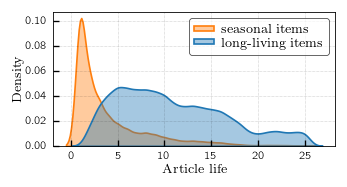

In [30]:
setup_plot(200, fig_ratio=0.5, style_sheet="base", font_size=8)
sns.kdeplot(data=ff, x="month_article_life", hue="cluster_label", fill=True, alpha=0.4, common_norm=True)
#sns.kdeplot(data=ff, x="month_article_life", fill=False, alpha=1, color="black", gridsize=100)

#handles, labels = plt.gca().get_legend_handles_labels()
#plt.gca().legend(handles=handles[1:], labels=labels[1:])
#plt.gca().get_legend().set_title(None)
#plt.gca().get_legend().get_frame().set_linewidth(0.5)
#plt.gca().get_legend(labels=["a", "b"])
plt.gca().legend(labels=["seasonal items", "long-living items"])
plt.gca().get_legend().get_frame().set_linewidth(0.5)
plt.xlabel("Article life")

plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.0)
plt.savefig(
    "{}/GitProjects/HnMChallenge/plots/{}.pdf".format(os.environ["HOME"], "cluster_life_distr"),
    #bbox_inches="tight",
)

In [31]:
pp =pd.melt(ff, id_vars=[DEFAULT_ITEM_COL, "cluster_label"], value_vars=[x for x in ff.columns if "month" in x and "life" not in x])

In [32]:
pp

,article_id,cluster_label,variable,value
0,0,0,month_0,0.324117
1,1,0,month_0,0.329646
2,2,1,month_0,0.833333
3,3,1,month_0,0.818330
4,4,1,month_0,0.889385
...,...,...,...,...
1254559,104542,1,month_11,0.000000
1254560,104543,1,month_11,0.000000
1254561,104544,1,month_11,0.000000
1254562,104545,1,month_11,0.000000


In [33]:
pp["month"] = pp["variable"].apply(lambda x: x.split("_")[-1]).astype(int)+1

In [34]:
pp

,article_id,cluster_label,variable,value,month
0,0,0,month_0,0.324117,1
1,1,0,month_0,0.329646,1
2,2,1,month_0,0.833333,1
3,3,1,month_0,0.818330,1
4,4,1,month_0,0.889385,1
...,...,...,...,...,...
1254559,104542,1,month_11,0.000000,12
1254560,104543,1,month_11,0.000000,12
1254561,104544,1,month_11,0.000000,12
1254562,104545,1,month_11,0.000000,12


In [35]:
pp[pp["month"]==1]

,article_id,cluster_label,variable,value,month
0,0,0,month_0,0.324117,1
1,1,0,month_0,0.329646,1
2,2,1,month_0,0.833333,1
3,3,1,month_0,0.818330,1
4,4,1,month_0,0.889385,1
...,...,...,...,...,...
104542,104542,1,month_0,1.000000,1
104543,104543,1,month_0,1.000000,1
104544,104544,1,month_0,1.000000,1
104545,104545,1,month_0,1.000000,1


Missing colon in file '/home/edoardo/GitProjects/InductiveRec/irec/experiments/plot/matplotlib_utils/styles/base.mplstyle', line 40 ('grid.zorder=-1')
/tmp/ipykernel_2351412/526244043.py:5: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f2592922d30> has a label of '_' which cannot be automatically added to the legend.
  plt.gca().legend(labels=["seasonal items", "_", "long-lived items", "_"])
/tmp/ipykernel_2351412/526244043.py:5: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f259292b3a0> has a label of '_' which cannot be automatically added to the legend.
  plt.gca().legend(labels=["seasonal items", "_", "long-lived items", "_"])


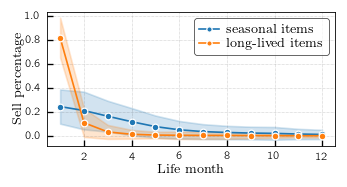

In [52]:
setup_plot(200, fig_ratio=0.5, style_sheet="base", font_size=8)

sns.lineplot(data=pp, y="value", x="month", hue="cluster_label", ci='sd', marker=".", markeredgecolor="white", markersize=8)

plt.gca().legend(labels=["seasonal items", "_", "long-lived items", "_"])
plt.gca().get_legend().get_frame().set_linewidth(0.5)
plt.xlabel("Life month")
plt.ylabel("Sell percentage")

plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.0)
plt.savefig(
    "{}/GitProjects/HnMChallenge/plots/{}.pdf".format(os.environ["HOME"], "cluster_relative_sell_distr"),
    #bbox_inches="tight",
)

Missing colon in file '/home/edoardo/GitProjects/InductiveRec/irec/experiments/plot/matplotlib_utils/styles/base.mplstyle', line 40 ('grid.zorder=-1')


<AxesSubplot:xlabel='month', ylabel='value'>

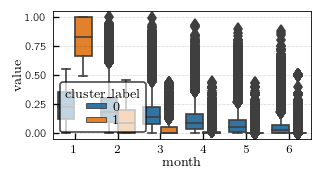

In [37]:
setup_plot(200, fig_ratio=0.5, style_sheet="base", font_size=8)
#sns.violinplot(data=pp[pp["month"]<=4], x="month", y="value", hue="cluster_label", split=True, inner="quart", alpha=0.4)
sns.boxplot(data=pp[pp["month"]<=6], x="month", y="value", hue="cluster_label")